# Module 3 : Core Learning Algorithms

## In this module:
  - Linear Regression
  - Classification
  - Clustering
  - Hidden Markov Models

본격적으로 NN에 대해 학습해보기 전, 기본적인 ML 알고리즘 4개에 대해 알아보도록 합시다.

수많은 syntax들이 등장하기 시작하는데, 싹 다 외울 필요는 없고 개인적으로는 무엇을 하고자 하는지 알고, 그것을 구현하기 위해 사용하고자 하는 라이브러리 document에서 잘 찾아 쓰기만 해도 된다고 생각합니다.

# Linear Regression

"Line of best fit refers to a line through a scatter plot of data points that best expresses the relationship between those points." (https://www.investopedia.com/terms/l/line-of-best-fit.asp)


원작자는 텐서플로 튜토리얼의 linear estimator를 기반으로 이 섹션을 만들었습니다. 해당 문서에서는 tf.estimator를 사용하여 logistic regression model을 훈련하였습니다.

https://www.tensorflow.org/tutorials/estimator/linear

## Basic example

우선 1개의 feature(x)와 1개의 label(y)로 이루어진 dataset을 보도록 하겠습니다.

[0, 5, 0, 20]

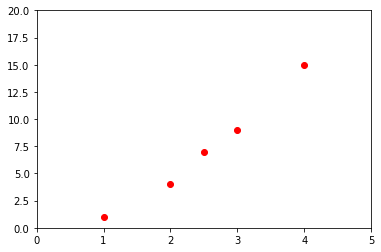

In [1]:
import matplotlib.pyplot as plt
import numpy as np

x = [1, 2, 2.5, 3, 4]
y = [1, 4, 7, 9, 15]
plt.plot(x, y, 'ro')
plt.axis([0, 5, 0, 20])

대강 선형 관계임을 확인할 수 있습니다. 이제 이 데이터를 잘 설명하는 선을 찾아봅시다. 1차식으로 regression을 한다고 하면 우리가 찾고자 하는 선은 다음과 같이 나타낼 수 있습니다.

$y = mx + b$

이제 가장 적절한 $m$, $b$를 찾아서 직선을 그려봅시다

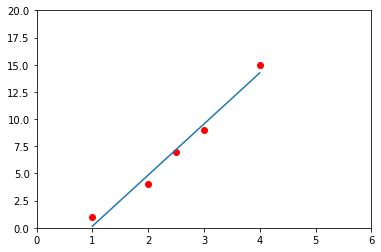

In [2]:
plt.plot(x, y, 'ro')
plt.axis([0, 6, 0, 20])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x))) #파란색 직선
plt.show()

Numpy에 포함된 ployfit 함수를 이용하여 주어진 데이터를 가장 잘 설명하는 직선의 계수를 찾을 수 있습니다. 세 번째 인자인 1은 1차식을 의미합니다. polyfit을 통해 구한 계수를 이용해 그린 직선은 꽤나 잘 5개의 점을 설명하고 있다고 할 수 있습니다.

feature의 개수가 많아지더라도 비어있는, 또는 구하고자 하는 label이 하나이면 regression이 가능합니다. 예를 들어, 중간고사 성적/기말고사 성적/과제 점수/출석 점수/프로젝트 점수 5개를 이용해서 최종 점수를 예상할 수 있겠죠. 이제 이런 regression을 tensorflow를 이용해서 해 보도록 합시다.

## Setup & Import

TF, Numpy 외에 scikit-learn도 같이 사용합니다. Scikit-learn은 데이터 분석, ML을 위한 오픈소스 라이브러리입니다.

In [3]:
import sklearn as sk
print(sk.__version__)

0.22.1


In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

## Data - Titanic

본 course에서는 타이타닉 데이터셋을 다루고 있습니다. 타이타닉호에 탑승했던 사람들의 인적사항 및 여러 정보들을 통해 생사 여부를 예측합니다. 먼저 데이터셋을 불러오고 y_train, y_eval에 정답에 해당하는 'survived'를 뽑아 저장합니다. 

*Kaggle에 올라온 titanic dataset과는 살짝 다릅니다.

In [5]:
x_train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # Training set
x_eval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # Test set
y_train = x_train.pop('survived')
y_eval = x_eval.pop('survived')

## Some useful pandas method

### df.head()

데이터는 pandas dataframe(df) 형식으로 저장됩니다. df.head()를 통해 첫 5개 아이템 정보를 볼 수 있습니다. 각 column의 정보는 다음과 같습니다.

 - sex : 성별
 - age : 나이
 - n_siblings_spouses : 같이 탑승한 형제자매 또는 배우자의 수
 - parch : 같이 탑승한 부모 또는 자식의 수
 - fare : 탑승 운임
 - class : 티켓 등급
 - deck : 객실 번호(구역)
 - embark_town : 탑승한 도시
 - alone : 혼자 탑승 여부

In [6]:
x_train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


다음은 정답에 해당하는 생존 여부입니다. 왼쪽이 index에 해당하고 오른쪽이 정답입니다. 정답은 생존 또는 사망 둘 중 하나이기 때문에 모두 1 또는 0으로 이루어져 있습니다.

In [7]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

### df.describe()

df.describe()를 통해 각 column의 통계 정보를 알 수 있습니다. Column 중 sex, class와 같이 숫자가 아닌 데이터가 있는 column은 표시하지 않습니다. 평균, 표준편차, 사분위수 등을 확인할 수 있습니다.

In [8]:
x_train.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


### df.shape

df.shape를 통해 데이터셋의 크기를 알 수 있습니다. 현재 사용하고 있는 데이터셋은 627개의 데이터와 9개의 feature로 이루어져 있습니다.

In [9]:
x_train.shape

(627, 9)

### df.loc()

다음으로 pandas에서 유용한 method인 loc에 대해 다뤄보겠습니다. 주어진 dataset에서 특정 부분만 따로 보고 싶을 때, df.loc[row index, column index]를 통해 원하는 정보만 따로 뽑아낼 수 있습니다. 다음은 첫 번째 데이터의 정보입니다. 

In [10]:
x_train.loc[0]

sex                          male
age                            22
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object

이번에는 첫 번째 데이터의 fare 정보만 보도록 하겠습니다.

In [11]:
x_train.loc[0, 'fare']

7.25

조금 더 나아가서, 특정 조건에 부합하는 데이터만 보도록 하겠습니다. 조건문을 통해 성별이 남자인 데이터만 뽑아보도록 합시다. row의 개수를 통해 데이터셋에 남자가 410명이라는 것을 알 수 있습니다.

In [12]:
x_train.loc[x_train.sex == 'male']

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
5,male,2.0,3,1,21.0750,Third,unknown,Southampton,n
9,male,20.0,0,0,8.0500,Third,unknown,Southampton,y
10,male,39.0,1,5,31.2750,Third,unknown,Southampton,n
...,...,...,...,...,...,...,...,...,...
619,male,19.0,0,0,7.8958,Third,unknown,Southampton,y
620,male,28.0,0,0,7.8958,Third,unknown,Southampton,y
622,male,28.0,0,0,10.5000,Second,unknown,Southampton,y
623,male,25.0,0,0,7.0500,Third,unknown,Southampton,y


## Visualization

이제 데이터를 눈에 보이는 그래프로 그려봅시다. 시각화를 통해 데이터의 특징을 보다 쉽게 확인할 수 있습니다.

우선 탑승자의 나이를 히스토그램으로 나타내봅시다. 나이 범위를 10등분하여 히스토그램을 그립니다. bins 값을 조절함으로써 각 막대에 해당하는 범위를 조절할 수 있습니다. 20-30대가 가장 많다는 것을 확인할 수 있습니다.

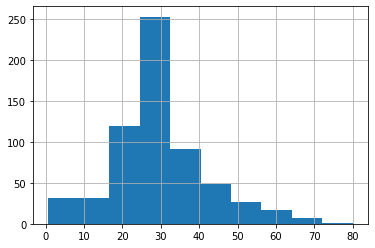

In [13]:
x_train.age.hist(bins = 10)

 다음으로는 숫자가 아닌 categorical feature의 시각화를 보도록 하겠습니다. 각 category의 등장 횟수를 value_counts()로 수집하여 막대그래프로 그릴 수 있습니다. 남성이 여성보다 많은 것을 확인할 수 있습니다.

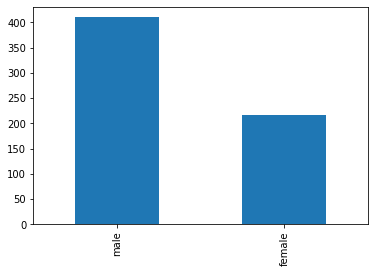

In [14]:
x_train.sex.value_counts().plot(kind = 'bar')

df['feature'] 형태로도 dataframe에서 특정 column을 뽑아서 볼 수 있습니다. 티켓 등급이 "Third"인 사람이 가장 많음을 확인할 수 있습니다.

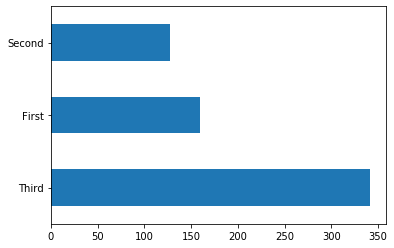

In [15]:
x_train['class'].value_counts().plot(kind = 'barh')

마지막으로 성별에 따른 생존율을 시각화해보도록 하겠습니다. 탑승자의 정보만 존재하는 x_train에 생존 여부가 존재하는 y_train을 pd.concat을 통해 합치고, 성별 정보를 통해 묶습니다. 

pd.concat([x_train, y_train], axis=1).groupby('sex')

성별을 통해 묶은 데이터에서 생존 여부(0, 1)의 평균을 구해서 다음과 같이 막대그래프로 그릴 수 있습니다.

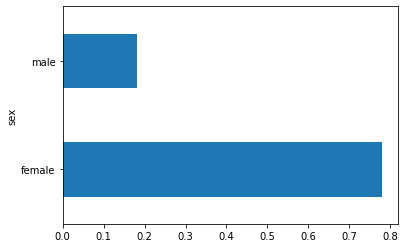

In [16]:
pd.concat([x_train, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh')

지금까지 수행한 시각화를 통해 다음과 같은 정보를 쉽게 알 수 있습니다.
  - 대부분의 탑승객은 20-30대
  - 남성 탑승객이 훨씬 많음
  - 대부분의 탑승객이 Third class
  - 여성의 생존 확률이 더 높음
    

## Training set // Test set

Training set을 통해 모델이 학습하고, test set을 통해 학습한 결과가 얼마나 잘 작동하는지 평가합니다. 이 때 training set과 test set은 서로 겹치지 않도록 해야합니다.

학습시킨 모델을 통해 새로운 데이터가 들어와도 잘 예측할 수 있어야 성공적인 모델이라고 할 수 있는데 학습 때 사용한 training set만 잘 맞추고 한 번도 보지 못했던 데이터(test data...)는 잘 예측하지 못하면 힙들게 학습시킨 의미가 없겠죠?

따라서 학습 시에는 training set만 사용하고, 학습시킨 모델을 평가할 때는 test set만 사용합니다. 여기서 정확도를 올리기 위해 validation을 하기도 하는데, 여기서는 생략하도록 하겠습니다.

## Feature engineering

(지금까지 경험한 바로는)가장 중요하다고 생각하는 feature engineering(특성 공학)입니다. ML/DL이란게 아무 데이터나 집어넣어도 모델이 좋으면 좋은 결과를 뚝딱 내놓는게 아닙니다. 좋은 결과를 예측하기 위해서는 잘 예측할 수 있도록 하는 정보들을 가공해서 모델에 넣어주는 것이 필수적입니다. 

앞서 언급한 중간고사 성적/기말고사 성적/과제 점수/출석 점수/프로젝트 점수를 통해 학점을 예측하고 싶은데 교수님의 성적 반영 비율이 중간고사:기말고사 = 50:50이고 나머지가 0이면 regression 때 과제/출석/프로젝트 점수는 굳이 넣을 필요가 없겠죠?

Regression과 타이타닉 데이터셋을 예로 들면, 결국 regression을 위해서는 input feature들이 숫자형이어야 하는데 주어진 데이터셋에는 sex, class 등의 feature가 string 형태입니다. 우선 이를 숫자로 변환시켜야 모든 feature들을 활용해서 regression이 가능합니다. 이러한 categorical feature들을 numeric feature로 바꿔봅시다.

### Categorical to numerical

class 정보를 예로 들면, ['first', 'second', 'third'] 3 종류가 있는데 이를 [0, 1, 2]와 같이 바꿔주면 됩니다. 굳이 first가 1이 될 필요는 없고, first가 모두 1로 변환되기만 하면 됩니다. 

여기서는 연속된 숫자 feature인 age, fare를 제외하고 나머지를 모두 categorical feature로 취급합니다.



In [17]:
cat_feature = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
num_feature = ['age', 'fare']

feature_columns = []
for feature_name in cat_feature:
  vocabulary = x_train[feature_name].unique()  # gets a list of all unique values from given feature column(ex. class : "First", "Second", "Third")
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)) # Generate column name 

for feature_name in num_feature:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns[0])
print(feature_columns[-1])

VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
NumericColumn(key='fare', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)


위 블록의 출력문을 통해 tf.feature_column.categorical_column_with_vocabulary_list(name, vocab)은 vocab에 담긴 목록을 기반으로 string을 int로 바꿔줍니다. 예를 들어 sex의 경우 vocab_list가 ['male', 'female']이므로 이를 [0, 1]로 바꿔준다는거죠. 

그리고 각 categorical feature에 담긴 vocab_list는 일일이 만들 필요 없이 x_train[feature_name].unique()를 통해 자동으로 vocab_list의 set을 이용해서 만들 수 있습니다.

Numeric feature는 numeric_column(name, dtype)을 통해 똑같이 작업할 수 있습니다. 연속형 특성이기 때문에 vocab_list 대신 자료형만 넣어주면 됩니다.

위에서 보여준 categorical_column_with_vocabulary의 공식 문서는 다음과 같습니다. 이해가 잘 가지 않는다면 참고하셔도 좋습니다.

https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list?version=stable

## Training Process

이제 regression을 위해 간단한 특성 공학까지 마쳤습니다. 이제 모델을 학습할 차례입니다. 정확히는, 모델에 데이터를 어떻게 넣는지부터 시작합니다.

지금 예제야 데이터가 작으니까 한 번에 집어넣어도 괜찮습니다만, 데이터가 무지막지하게 커지게 되면 한 번에 모든 데이터를 올려서 학습을 시킬 수가 없습니다. 이 경우, 데이터를 batch로 나눠서 집어넣게 됩니다. batch size = 32면 데이터를 32개의 batch 여러개로 나눠서 모델에 넣는다는 의미입니다.

또한, 각 batch를 여러번 넣어서 학습하게 됩니다. 이 횟수를 epoch이라고 하는데, 간단하게 1 epoch은 모든 데이터셋을 한 번 넣었다는 의미입니다. 10 epoch을 돌렸다는 것은 모든 데이터를 10번 넣어서 학습시켰다는 의미입니다.

이러한 작업들을 쉽게 수행하기 위해 input function을 사용하게 됩니다. Input function을 사용해서 쉽게 데이터를 여러 batch로 나눠서 epoch 수만큼 돌릴 수 있습니다.

### Input function

이제 사용할 모델은 input의 형태로 tf.data.Dataset을 요구합니다. 지금까지 사용했던 데이터셋은 pandas dataframe이었기 때문에 input function을 통해 적절하게 수정해 줄 필요가 있습니다.

다음은 텐서플로 공식 튜토리얼에서 긁어온 input function 예시입니다. 다음과 같은 파라미터를 필요로 합니다.
  - Input dataframe (ex. x_train)
  - Label dataframe (ex. y_train)
  - num_epoch : 전체 데이터를 반복하는 횟수
  - shuffle : Input_data를 섞어서 batch로 나누는 지 여부
  - batch_size : 한 번 학습 시 동시에 학습되는 데이터의 개수
  
tf.data.Dataset.from_tensor_slices는 입력된 array, list 또는 dictionary로부터 tf.data.Dataset 객체를 만들어준다. 예를 들어, 28x28 사이즈의 이미지 10000개가 [10000, 28, 28] shape의 array로 들어간다면 28x28 사이즈의 데이터 10000개의 slice를 만들게 됩니다.

본 예시의 경우에는 각 dictionary의 9개 key마다 627개의 value가 저장이 된 상태로 들어가게 됩니다.

In [18]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(x_train, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(x_eval, y_eval, num_epochs=1, shuffle=False)

결국 가장 바깥의 make_input_fn 함수는 주어진 파라미터에 따라 데이터를 만드는 input function을 만들어서 return하게 된다.

Test set의 경우 결과 확인은 한 번만 진행하면 되고, 섞을 필요가 없기 때문에 num_epochs=1, shuffle=False로 한다.

### Creating Model

텐서플로에서 제공하는 linear estimator를 사용한다. 위에서 만들어둔 feature_columns를 estimator에 넣어준다

In [19]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp1vqev21s', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Training Model

앞서 만든 linear estimator를 학습시킨다. input으로 위에서 만든 training set에 대한 input function을 넣어준다. estimator.train(training_set)으로 학습을 시키고 estimator.evaluate(test_set)으로 test set에 대한 결과를 출력한다.

clear_output()을 실행하지 않으면 뭔가 경고...가 많이 뜨는 것 같은데 무슨 의미인지는 아직 모르겠다. 아마 자료형에 관한 이야기인 것 같다. clear_output을 수행하면 결과를 출력하기 전 출력된 것들을 지울 수 있다. 경고문을 제외하면 각 step마다 loss를 출력해준다.

Result는 다양한 metric을 포함하고 있다. 10개의 metric을 포함하고 있는 것 같다. global_step은 총 몇 개의 batch를 학습했는가를 의미한다. 627개를 32개로 나누면 20개의 batch가 나오니 우리의 경우 global step = epoch * 20이 되겠다.

특성 공학 부분과는 다르게 실제 모델을 만들어서 돌리는 부분의 코드는 아직까지는 복잡하지 않다. tf.estimator에는 다양한 종류의 estimator가 있으니 궁금한 사람들은 찾아보도록 하자.

In [20]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears console output
print(result)  # the result variable is simply a dict of stats about our model

{'accuracy': 0.7765151, 'accuracy_baseline': 0.625, 'auc': 0.8355984, 'auc_precision_recall': 0.7922622, 'average_loss': 0.4739177, 'label/mean': 0.375, 'loss': 0.4656005, 'precision': 0.72727275, 'prediction/mean': 0.3513966, 'recall': 0.64646465, 'global_step': 200}


간단한 linear regression을 통해 약 75%의 정확도를 얻었다. 이정도면 단순 linear regression 치고는 꽤.... 정확하지 않을까?

이렇게 모델을 학습시켰으니 모델이 test set의 데이터를 어떻게 예측했는지 직접 확인해볼 수 있다. estimator.evaluate() 대신 estimator.predict()를 통해 특정 data가 들어갔을 때 예측값을 확인할 수 있다.

첫 번째 데이터의 예측 결과를 보도록 하자. 'probabilities'값이 [0.9347821 , 0.06521789]이므로 0이 사망이라면 이 탑승객이 사망했을 것이라고 93% 예측한 것이다. y_eval[0]값이 0이므로 우리의 모델은 이 탑승객의 생존 여부를 정확히 맞췄다고 할 수 있다.

In [24]:
predict = list(linear_est.predict(eval_input_fn))

clear_output()
print(predict[0])

{'logits': array([-2.6625795], dtype=float32), 'logistic': array([0.0652179], dtype=float32), 'probabilities': array([0.9347821 , 0.06521789], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}


다음과 같이 탑승객의 정보와 생존 여부, 예측한 생존 확률을 같이 출력해서 볼 수도 있다.

In [29]:
print(x_eval.loc[100])
print("Survive       :", y_eval.loc[100])
print("Survive prob. :", predict[100]['probabilities'][1])

sex                          male
age                            30
n_siblings_spouses              0
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           y
Name: 100, dtype: object
Survive       : 0
Survive prob. : 0.07395977
